In [168]:
import glob
import os
import re
import math
from decimal import Decimal
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.cm
import pandas as pd
import numpy as np
import time

hydrogen_frac = 'H100'
#Enter path to run directory where NuGrid data is stored (must contain isotopedatabase.txt and iso_massf files)
path = '/shared/storage/physnp/seda500/nugrid/nuppn/frames/ppn/runs/2025.04.15runs/f1a5mcr1.5md16e-5/N_Traj_rmin=1.3027E+06/'
#path = '/shared/storage/physnp/ahs539/Nugrid/NuPPN/frames/ppn/Fryer_Run_dir/' + hydrogen_frac + '_oct_2023/f1a5mcr1.5md64e-5/N_Traj_rmin=2.0355E+06/'
#enter a name for saving figuresmkdi
run_name = 'Sophie_O12_badness'
save_path = '/shared/storage/physnp/ahs539/H_frac_variation_flux_plots/64e-5_acc_rate/'
#save figure? 
save_figure = True #False/True



#read in the list of stable isotopes for plotting
dtype = [('col1', int), ('col2', 'int'), ('col3', 'U1'), ('col4', 'U1'), 
         ('col5', 'U10'), ('col6', float), ('col7', float), ('col8', float), ('col9', int)]
stable_list = pd.read_csv('Stable_isotope.DAT', header=None, skiprows=47,  sep='\s+')
stable = stable_list.values.tolist()
only_stable = []
for I in range(len(stable)):
    if stable[I][2] == '-':
        only_stable.append(stable[I][0:4])

# Flux data plotting with all timesteps 

In [169]:
list = sorted(os.listdir(path) )
flux = [x for x in list if x.startswith('flux') and x.endswith('.DAT')]
Mass = [x for x in list if x.startswith('iso_massf') and x.endswith('.DAT')]
print('Total number of timesteps in trajectory: ' + str(len(flux)))
temp = input('type the timestep you would like: ')
timestep = int(temp)

Total number of timesteps in trajectory: 201


type the timestep you would like:  200


In [170]:
flux_in = pd.read_csv(path + flux[timestep], sep='\s+',#
                          usecols =[x for x in range(0,11)], dtype='float')
#Convert to a list. 
flux_in_list = flux_in.values.tolist()

#Now we need to get the maximum of, store test, just 9th index,
flux_data = flux_in_list

with open(path + Mass[timestep]) as f:
    for line in f:
        if line.startswith(' #'):
            match = re.search(r't9\s*=\s*([\d.E+-]+)\s+rho\s*=\s*([\d.E+-]+)', line)
            if match:
                t9 = float(match.group(1))
                rho = float(match.group(2))

In [171]:
np_flux = np.array(flux_in_list, dtype='float')  # sets all values to float
max_value = max(row[9] for row in np_flux)
print('maximum flux value = ' + str(max_value))

maximum flux value = 26839000.0


## Limits and parameters

In [172]:
#Limits and parameters
Max_Z = 50
Min_Z = -1
Max_N = 50
Min_N = -1
flux_up_Lim = 2e7
flux_Lim = 1e-5
alpha = 0.8 # level of transparency 
top_iso = []

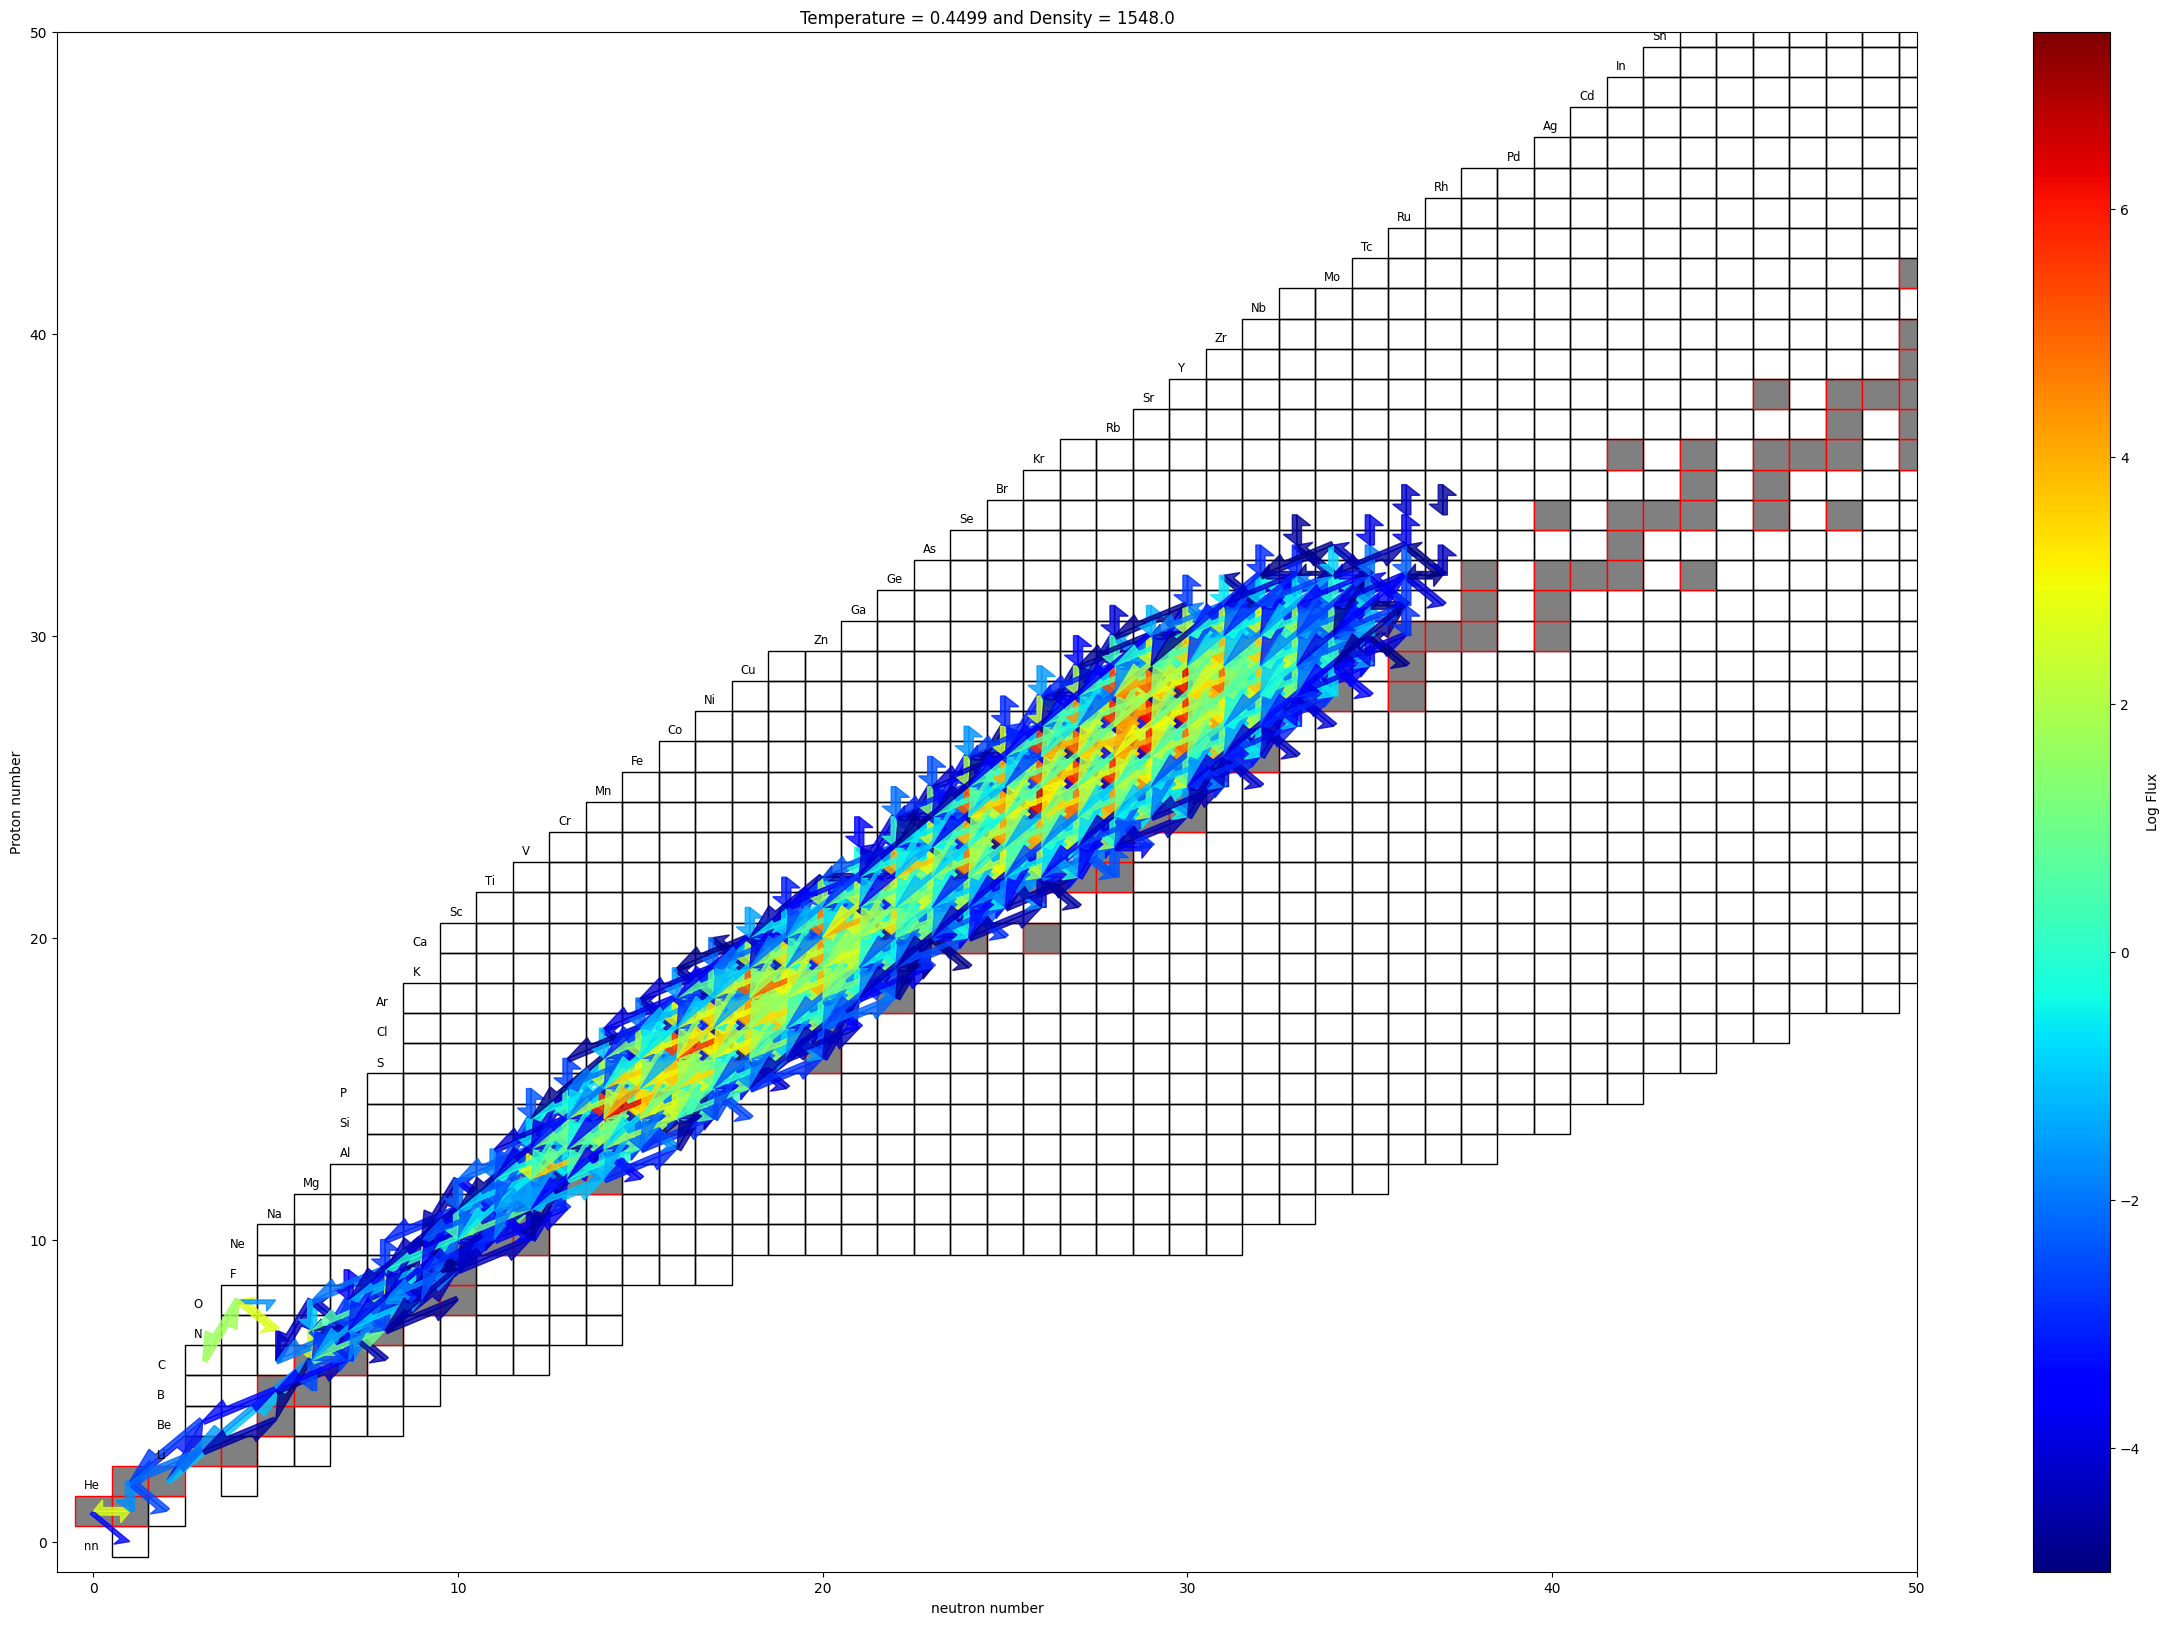

In [173]:
fig, ax = plt.subplots(figsize=(30,20))
plt.xlim(-1, 200)#template limits - set these larger than the highest Z and A isotope 
plt.ylim(-1, 85)

#Readin isotopedatabase.txt into pandas array 
iso_db_in = pd.read_csv(path + 'isotopedatabase.txt', sep='\s+', 
                        skiprows=3, header = None, dtype='string', #skip to isotope data in file reading
                        usecols=[x for x in range(0,5)]) # use only 6 columns to store data (shape of file)
iso_db_list = iso_db_in.values.tolist()


#add the rextangles
j = 0
for i in range(len(iso_db_list)): # list through each isotope
    iso_db_list[i][0] = float(iso_db_list[i][0])#convert Z to float
    iso_db_list[i][1] = float(iso_db_list[i][1])#convert A to float
    plt.gca()
    if iso_db_list[i][0] == float(only_stable[j][0]) and iso_db_list[i][1] == float(only_stable[j][1]):
        art = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='grey', ec='r', fill =True, lw =1) #draw box around each isotope
        #ax.text(iso_db_list[i][1]-iso_db_list[i][0] , iso_db_list[i][0], iso_db_list[i][2] + str(int(iso_db_list[i][1])), ha = 'center', va = 'center', fontsize = 'small', clip_on = True)#add isotope label
        
        j = j +1
    else:    
        art = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='k', fill =False, lw =1) #draw box around each isotope
    ax.add_patch(art)
    plt.gcf()
    #ax.text(iso_db_list[i][1]-0.45-iso_db_list[i][0] , iso_db_list[i][0]-0.45, iso_db_list[i][2] + str(int(iso_db_list[i][1])), fontsize = 'small', clip_on = True)#add isotope label
    if iso_db_list[i][2] != iso_db_list[i-1][2]:
        plt.gcf()
        ax.text(iso_db_list[i][1]-1.25-iso_db_list[i][0], iso_db_list[i][0]-0.25, iso_db_list[i][2], fontsize ='small', clip_on = True)#add isotope label


cmap = plt.get_cmap('jet')  # 'cubehelix' other colour maps can be used
norm = matplotlib.colors.Normalize(vmin=math.log(flux_Lim, 10), vmax=math.log(max_value, 10))#vmax=math.log(flux_up_Lim, 10))  # normalizes the color value between the max A and min Lim
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
scalarMap.set_array([])

for J in range(len(flux_data)):
    if float(flux_data[J][9]) > flux_Lim and float(flux_data[J][9]) < flux_up_Lim:
        plt.gcf()
        ax.arrow(
            float(flux_data[J][2]) - float(flux_data[J][1]),
            float(flux_data[J][1]),
            (float(flux_data[J][8]) - float(flux_data[J][7]) - (float(flux_data[J][2]) - float(flux_data[J][1]))),
            (float(flux_data[J][7]) - float(flux_data[J][1])),
            width=0.25,
            shape='left',
            length_includes_head=True,
            head_length=0.25 * math.sqrt(
                ((float(flux_data[J][8]) - float(flux_data[J][2])) ** 2) +
                ((float(flux_data[J][7]) - float(flux_data[J][1])) ** 2)
            ),
            color=cmap(norm(math.log(float(flux_data[J][9]), 10))),
            alpha=alpha
        )  # Draw the flux arrow

# Add colorbar to the axis
cbar = fig.colorbar(scalarMap, ax=ax, label='Log Flux', orientation='vertical')

# Set the title
ax.set_title('Temperature = ' + str(t9) + ' and Density = ' + str(rho))
ax.set_ylabel('Proton number')
ax.set_xlabel('neutron number')
# Show the plot
plt.xlim(Min_N, Max_N)
plt.ylim(Min_Z, Max_Z)

if save_figure == True:
    plt.savefig(save_path + '/' + run_name + '_' + hydrogen_frac + '_' + flux[timestep] + '_chart.png',  bbox_inches='tight')
else:
    plt.show()
